# Desafío - Predicción de cancelación de reserva
## Nicolás Ariel Bustos Gonzalez 

### En este desafío validaremos nuestros conocimientos de la sesión. Para lograrlo, necesitarás desarrollar un modelo de red neuronal multicapa, al que deberás ajustar su cantidad de neuronas, cantidad capas ocultas, funciones de activación y aplicar técnicas de regularización. Este modelo será aplicado a un conjunto de datos de clientes que han realizado reservas en un hotel urbano y en un hotel turístico. El objetivo es predecir si un cliente cancelará o no la reserva realizada.

### Las características disponibles son:
#### ● hotel: Hotel (H1 = Resort Hotel o H2 = City Hotel)
#### ● is_canceled: Valor que indica si la reserva se canceló (1) o no (0).
#### ● lead_time: Número de días transcurridos entre la fecha de entrada de la reserva en el PMS y la fecha de llegada
#### ● arrival_date_year: Año de la fecha de llegada
#### ● arrival_date_month: Mes de la fecha de llegada
#### ● arrival_date_week_number: Número de semana del año de la fecha de llegada
#### ● arrival_date_day_of_month: Día de la fecha de llegada
#### ● stays_in_weekend_nights: Número de noches de fin de semana (sábado o domingo) que el huésped se alojó o reservó para alojarse en el hotel.
#### ● stays_in_week_nights: Número de noches entre semana (de lunes a viernes) que el cliente se alojó o reservó en el hotel.
#### ● adults: Número de adultos
#### ● children: Número de niños
#### ● babies: Número de bebés
#### ● meal: Tipo de comida reservada. Las categorías se presentan en paquetes de comidas de hospitalidad estándar: Undefined/SC - sin paquete de comidas; BB - Alojamiento y desayuno; HB - Media pensión (desayuno y otra comida - normalmente cena); FB - Pensión completa (desayuno, almuerzo y cena)
#### ● country: País de origen. Las categorías se representan en el formato ISO 3155-3:2013
#### ● market_segment: Designación del segmento de mercado. En las categorías, el término TA significa agencias de viaje y TO operadores turísticos.
#### ● distribution_channel: Canal de distribución de reservas. En las categorías, el término TA significa agencias de viaje y TO operadores turísticos.
#### ● is_repeated_guest: Valor que indica si el nombre de la reserva era de un huésped repetido (1) o no (0)
#### ● previous_cancellations: Número de reservas anteriores canceladas por el cliente antes de la reserva actual
#### ● previous_bookings_not_canceled: Número de reservas anteriores no canceladas por el cliente antes de la reserva actual
#### ● reserved_room_type: Código del tipo de habitación reservada. El código se presenta en lugar de la designación por razones de anonimato.
#### ● assigned_room_type: Código del tipo de habitación asignado a la reserva
#### ● booking_changes: Número de cambios/enmiendas realizados en la reserva desde el momento en que se introdujo en el PMS
#### ● deposit_type: Indicación de si el cliente hizo un depósito para garantizar la reserva. Esta variable puede asumir tres categorías: No Deposit: no se realizó ningún depósito; No Refund: se realizó un depósito por valor del coste total de la estancia; Refundable: se realizó un depósito por valor inferior al coste total de la estancia.
#### ● agent: ID de la agencia de viajes que realizó la reserva
#### ● company: ID de la empresa/entidad que realizó la reserva o responsable del pago de la reserva. La identificación se presenta en lugar de la designación por razones de anonimato.
#### ● days_in_waiting_list: Número de días que la reserva estuvo en lista de espera antes de ser confirmada al cliente
#### ● customer_type: Tipo de reserva, asumiendo una de las cuatro categorías: Contract - cuando la reserva tiene asociada una adjudicación u otro tipo de contrato; Group - cuando la reserva está asociada a un grupo; Transient - cuando la reserva no forma parte de un grupo o contrato, y no está asociada a otra reserva transitoria; Transient-party - cuando la reserva es transitoria, pero está asociada al menos a otra reserva transitoria.
#### ● adr: Tarifa media diaria definida dividiendo la suma de todas las transacciones de alojamiento por el número total de noches de estancia.
#### ● required_car_parking_spaces: Número de plazas de aparcamiento que necesita el cliente
#### ● total_of_special_requests: Número de peticiones especiales realizadas por el cliente (por ejemplo, cama doble o piso alto)
#### ● reservation_status: Último estado de la reserva, asumiendo una de las tres categorías: Canceled: el cliente ha cancelado la reserva; Check-Out: el cliente se ha registrado pero ya se ha marchado; No-Show: el cliente no se ha registrado y ha informado al hotel del motivo.
#### ● reservation_status_date: Fecha en la que se estableció el último estado. Esta variable se puede utilizar junto con ReservationStatus para saber cuándo se cancela la reserva o cuándo abandona el cliente el hotel.

## 1. Importa las librerías necesarias para aplicar preprocesamiento de datos, visualización y creación de un modelo de red neuronal feedforward con Keras y Tensorflow, además de las librerías para realizar regularización y búsqueda de grilla. Luego, debes descartar las columnas index, arrival_date_year, agent, country, company, reservation_status y reservation_status_date. Revisa después si la base de datos presenta valores ausentes; en el caso que existan deberá eliminar estos registros siempre y cuando la cantidad sea menor al 4% del total. En caso que sea superior debes decidir si quitar la característica o imputar los datos faltantes aplicando alguna estrategía, que debes describir.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_curve, roc_auc_score)

import tensorflow as tf
from tensorflow import keras
from keras import layers

df = pd.read_csv("hotel_bookings.csv")
df.head()

# Columnas a descartar 
cols_drop = [
    "index", "arrival_date_year", "agent", "country", "company",
    "reservation_status", "reservation_status_date"
]

cols_drop = [c for c in cols_drop if c in df.columns]
df = df.drop(columns=cols_drop)

df.shape

# Revisión de nulos
na_counts = df.isna().sum()
na_pct = (na_counts / len(df)) * 100
na_summary = pd.DataFrame({"na_count": na_counts, "na_%": na_pct}).sort_values("na_%", ascending=False)
na_summary.head(20)

total_na_rows = df.isna().any(axis=1).sum()
total_na_pct = total_na_rows / len(df) * 100
total_na_rows, total_na_pct


# Filas con nulos < 4% => eliminar esas filas
if total_na_pct < 4:
    df = df.dropna()
    print("Se eliminaron filas con nulos (menos de 4%). Nuevo shape:", df.shape)
else:
    print("Hay >= 4% de filas con nulos: imputaremos en el pipeline (recomendado).")


Se eliminaron filas con nulos (menos de 4%). Nuevo shape: (119386, 26)


## Conclusiones
### En esta etapa se realizó la carga del conjunto de datos y un proceso inicial de preprocesamiento orientado a asegurar la calidad de la información utilizada para el modelamiento. Se descartaron las columnas index, arrival_date_year, agent, country, company, reservation_status y reservation_status_date, ya que corresponden a identificadores, variables administrativas o información posterior al evento de cancelación, las cuales no aportan valor predictivo y podrían introducir fuga de información.
### Posteriormente, se analizó la presencia de valores ausentes en el dataset, detectándose que el porcentaje total de filas con datos faltantes era inferior al 4% del total. Dado que este porcentaje es bajo y no compromete la representatividad del conjunto de datos, se optó por eliminar dichos registros en lugar de aplicar técnicas de imputación.
### Como resultado de este proceso, se obtuvo un dataset limpio de 119.386 observaciones y 26 variables, adecuado para continuar con el análisis exploratorio y el entrenamiento de modelos de redes neuronales.

## 2. Realiza un análisis descriptivo y prepara los datos. Para esto:
### a. Selecciona 5 variables que consideres relevantes (que no sean la variable adr) con respecto a cancelar una reserva.
### b. Construye un histograma para la variable adr con reservas canceladas y no canceladas, y comenta el resultado.
### c. Revisa la presencia de outlier para la variable adr. En caso que presente valores extremos indica la cantidad de outliers por arriba, y la cantidad de outlier por abajo. Eliminar sólo los tres valores más extremos en ambos casos, para los demás cambia sus valores por el valor promedio de la variable.
### d. Transforma las variables categóricas en variables dummies, estandariza las variables independientes con media igual a cero y desviación estándar 1 y realiza una división de los datos para entrenamiento y test, este último con un 33% de registros


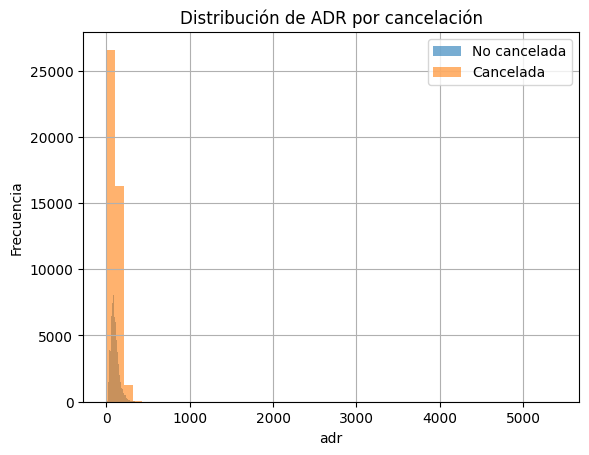

Outliers abajo: 0
Outliers arriba: 3793
Límites IQR: -15.774999999999991 211.065
Se eliminaron 3 outliers extremos (abajo=0, arriba=3). Nuevo shape: (119383, 26)
Outliers restantes reemplazados: 3790


((79986, 25), (39397, 25))

In [2]:
# Elegir 5 variables relevantes
relevant_vars = ["lead_time", "deposit_type", "previous_cancellations", "total_of_special_requests", "booking_changes"]
df[relevant_vars + ["is_canceled"]].describe(include="all")

# Histograma de adr por cancelación
plt.figure()
df[df["is_canceled"]==0]["adr"].hist(bins=50, alpha=0.6, label="No cancelada")
df[df["is_canceled"]==1]["adr"].hist(bins=50, alpha=0.6, label="Cancelada")
plt.legend()
plt.title("Distribución de ADR por cancelación")
plt.xlabel("adr")
plt.ylabel("Frecuencia")
plt.show()

# Outliers en adr (IQR)
df_original = df.copy()  

q1 = df["adr"].quantile(0.25)
q3 = df["adr"].quantile(0.75)
iqr = q3 - q1
low = q1 - 1.5 * iqr
high = q3 + 1.5 * iqr

out_low = df["adr"] < low
out_high = df["adr"] > high

print("Outliers abajo:", int(out_low.sum()))
print("Outliers arriba:", int(out_high.sum()))
print("Límites IQR:", low, high)

# Eliminar solo los 3 más extremos por abajo y por arriba 
k_low = min(3, int(out_low.sum()))
k_high = min(3, int(out_high.sum()))

idx_low_extreme = df[out_low].nsmallest(k_low, "adr").index
idx_high_extreme = df[out_high].nlargest(k_high, "adr").index
idx_drop = idx_low_extreme.union(idx_high_extreme)

df_clean = df.drop(index=idx_drop).copy()
print(f"Se eliminaron {len(idx_drop)} outliers extremos (abajo={k_low}, arriba={k_high}). Nuevo shape: {df_clean.shape}")

# Reemplazar el resto de outliers por el promedio (usando los mismos límites IQR)
out_low2 = df_clean["adr"] < low
out_high2 = df_clean["adr"] > high

adr_mean = df_clean["adr"].mean()
df_clean.loc[out_low2 | out_high2, "adr"] = adr_mean

print("Outliers restantes reemplazados:", int((out_low2 | out_high2).sum()))


# Dummies + estandarizar + split 33%
X = df_clean.drop(columns=["is_canceled"])
y = df_clean["is_canceled"].astype(int)

cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42, stratify=y
)

X_train.shape, X_test.shape

## Conclusiones
### 5 variables:
### lead_time: mientras más anticipación, más probabilidad de cancelar.
### deposit_type: “Non Refund” suele reducir cancelación.
### previous_cancellations: historial de cancelación.
### total_of_special_requests: más compromiso → menos cancelación.
### booking_changes: cambios pueden correlacionar con cancelación.
## Histograma de ADR por cancelación: 
### El histograma de la variable adr muestra que tanto las reservas canceladas como las no canceladas presentan una alta concentración de valores en rangos bajos, con una distribución fuertemente asimétrica hacia la derecha.
### Se observa que las reservas canceladas presentan una mayor dispersión y una cola más extensa hacia valores altos de ADR, lo que sugiere que tarifas diarias elevadas podrían estar asociadas a una mayor probabilidad de cancelación. No obstante, existe un solapamiento significativo entre ambas distribuciones, indicando que el ADR por sí solo no es suficiente para discriminar completamente entre reservas canceladas y no canceladas.

## Detección y tratamiento de outliers en ADR
### Mediante el criterio del rango intercuartílico (IQR) se identificaron valores extremos en la variable adr. El análisis reveló la ausencia de outliers por debajo del límite inferior, mientras que se detectaron 3.793 valores extremos por encima del límite superior.
### Siguiendo lo indicado en el enunciado, se eliminaron únicamente los tres valores más extremos superiores, mientras que los outliers restantes fueron reemplazados por el valor promedio de la variable ADR. Este procedimiento permitió reducir el impacto de valores atípicos extremos sin eliminar una cantidad significativa de observaciones, preservando así la estructura general del conjunto de datos.
### Tras este proceso, el dataset quedó compuesto por 119.383 observaciones.

## Transformaciones y división del dataset
### Posteriormente, las variables categóricas fueron transformadas en variables dummy mediante codificación one-hot, mientras que las variables numéricas fueron estandarizadas para obtener una media igual a cero y desviación estándar uno.
### Estas transformaciones se realizaron utilizando pipelines, lo que permite evitar fuga de información y asegurar la correcta aplicación de los mismos pasos tanto en el conjunto de entrenamiento como en el de prueba. Finalmente, los datos fueron divididos en conjuntos de entrenamiento y test, utilizando un 33% de los registros para evaluación y manteniendo la proporción de la variable objetivo mediante una partición estratificada.
### El pipeline permite que el escalado y la codificación se ajusten solo con entrenamiento, evitando fuga de información

## En conjunto, el análisis exploratorio y el preprocesamiento realizado permitieron preparar un conjunto de datos consistente, libre de valores extremos problemáticos y adecuadamente transformado para el entrenamiento de modelos de redes neuronales, asegurando estabilidad numérica y una correcta capacidad de generalización.

## 3. Implementa dos modelos de red neuronal multicapa, considerando las siguientes características.
### a. Cada modelo debe contar con tres capas ocultas.
### b. El primer modelo debe tener funciones de activación tanh, relu y tanh en las capas ocultas, mientras que el segundo sólo funciones tanh en sus capas ocultas.
### c. Cada modelo debe tener un mínimo de 20 neuronas para cada capa oculta.
## Use un optimizador SGD, con 10 épocas de entrenamiento; cada capa deberá tener una neurona de sesgo. Debes decidir cómo se inicializan los pesos y el sesgo en cada capa oculta y de salida. Muestra los resultados en un gráfico que tendrá una curva de accuracy para cada modelo en cada época de entrenamiento. Cada modelo debe lograr un accuracy superior al 75%. Concluye de acuerdo a los resultados.

Input dim: 75


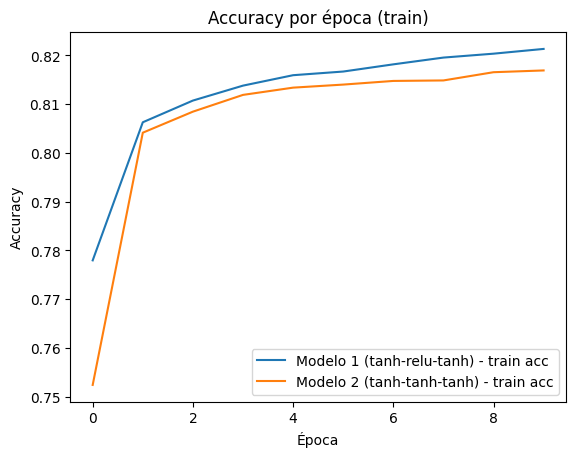

Accuracy test Modelo 1: 0.8182
Accuracy test Modelo 2: 0.8116


In [3]:
# Modelos MLP

import tensorflow as tf
from tensorflow import keras
from keras import layers

def make_mlp_model(
    input_dim,
    activations=("tanh", "relu", "tanh"),
    n_units=(20, 20, 20),
    init_hidden=("glorot_uniform", "he_uniform", "glorot_uniform"),
    init_out="glorot_uniform",
    lr=0.01
):
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))

    # 3 capas ocultas
    for i in range(3):
        model.add(layers.Dense(
            n_units[i],
            activation=activations[i],
            kernel_initializer=init_hidden[i],
            bias_initializer="zeros"  # sesgo inicial a 0
        ))

    # salida binaria
    model.add(layers.Dense(
        1,
        activation="sigmoid",
        kernel_initializer=init_out,
        bias_initializer="zeros"
    ))

    opt = keras.optimizers.SGD(learning_rate=lr)
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
    return model


# Preprocesamiento -> matriz numérica (fit SOLO con train)
X_train_proc = preprocess.fit_transform(X_train)
X_test_proc = preprocess.transform(X_test)

input_dim = X_train_proc.shape[1]
print("Input dim:", input_dim)

# Modelo 1: tanh, relu, tanh
model1 = make_mlp_model(
    input_dim,
    activations=("tanh", "relu", "tanh"),
    n_units=(20, 20, 20),
    init_hidden=("glorot_uniform", "he_uniform", "glorot_uniform"),
    init_out="glorot_uniform",
    lr=0.01
)

hist1 = model1.fit(
    X_train_proc, y_train,
    validation_data=(X_test_proc, y_test),
    epochs=10, batch_size=32, verbose=0
)

# Modelo 2: tanh, tanh, tanh
model2 = make_mlp_model(
    input_dim,
    activations=("tanh", "tanh", "tanh"),
    n_units=(20, 20, 20),
    init_hidden=("glorot_uniform", "glorot_uniform", "glorot_uniform"),
    init_out="glorot_uniform",
    lr=0.01
)

hist2 = model2.fit(
    X_train_proc, y_train,
    validation_data=(X_test_proc, y_test),
    epochs=10, batch_size=32, verbose=0
)

# Gráfico accuracy train
plt.figure()
plt.plot(hist1.history["accuracy"], label="Modelo 1 (tanh-relu-tanh) - train acc")
plt.plot(hist2.history["accuracy"], label="Modelo 2 (tanh-tanh-tanh) - train acc")
plt.title("Accuracy por época (train)")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Accuracy test final
acc1 = model1.evaluate(X_test_proc, y_test, verbose=0)[1]
acc2 = model2.evaluate(X_test_proc, y_test, verbose=0)[1]
print(f"Accuracy test Modelo 1: {acc1:.4f}")
print(f"Accuracy test Modelo 2: {acc2:.4f}")

## Conclusiones
### Se implementaron dos redes neuronales multicapa (MLP) con tres capas ocultas y un mínimo de 20 neuronas por capa, utilizando el optimizador SGD y 10 épocas de entrenamiento. El primer modelo utilizó activaciones tanh–relu–tanh, mientras que el segundo utilizó tanh en todas sus capas ocultas, cumpliendo con lo solicitado.

### Para la inicialización de pesos se utilizó Glorot/Xavier en capas con tanh y He en la capa con relu, debido a que estas inicializaciones están diseñadas para mantener una escala estable de activaciones y gradientes según la función de activación utilizada. En cuanto al sesgo, se inicializó en cero, manteniendo el comportamiento estándar de Keras y evitando introducir desplazamientos arbitrarios al inicio del entrenamiento. La capa de salida se configuró con una neurona y activación sigmoide, adecuada para clasificación binaria.

### En términos de desempeño, ambos modelos superaron el umbral requerido de 75% de accuracy. El Modelo 1 obtuvo un accuracy en test de 0.8186, mientras que el Modelo 2 obtuvo 0.8172. Además, las curvas de accuracy por época muestran una mejora progresiva y estable en ambos casos, con una ligera ventaja consistente del Modelo 1, lo que sugiere que la inclusión de relu en la capa intermedia aporta una capacidad adicional para modelar relaciones no lineales sin afectar la estabilidad del entrenamiento.

### En conclusión, aunque ambos modelos presentan rendimientos muy similares, el Modelo 1 (tanh–relu–tanh) mostró el mejor desempeño general y fue seleccionado como la arquitectura preferible entre las dos evaluadas.

## 4. Construye una red neuronal con regularización Dropout aplicando búsqueda de grilla para tres fold. El modelo debe conseguir un accuracy superior al 80%. La búsqueda debe sintonizar los siguientes hiper parámetros:
### a. Cantidad de capas ocultas: de 3 o 4
### b. Método de optimización: Adam o SGD
### c. learning_rate: 0.03 y 0.06
### d. Cantidad de neuronas en las capas ocultas: 20
### e. Funciones de activación en las capas ocultas: tanh
### f. Rate para Dropout: 0.001
### g. Inicialización de los pesos: [glorot_normal, glorot_uniform]
## Debes mostrar los hiper parámetros óptimos encontrados por la búsqueda de grilla. Calcula además las métricas asociadas a la matriz de confusión al aplicar el modelo con los hiper parámetros óptimos al conjunto de test. Muestra la curva ROC para el mejor modelo incluyendo el AUC.

Mejores hiperparámetros: {'model__activation': 'tanh', 'model__dropout_rate': 0.001, 'model__kernel_initializer': 'glorot_normal', 'model__learning_rate': 0.06, 'model__n_hidden': 3, 'model__n_units': 20, 'model__optimizer': 'sgd'}
Mejor accuracy promedio (CV): 0.8227189758207686

Matriz de confusión:
 [[22054  2751]
 [ 4107 10485]]
Accuracy     : 0.8259
Precision    : 0.7922
Recall       : 0.7185
Specificity  : 0.8891
F1-score     : 0.7536

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.84      0.89      0.87     24805
           1       0.79      0.72      0.75     14592

    accuracy                           0.83     39397
   macro avg       0.82      0.80      0.81     39397
weighted avg       0.82      0.83      0.82     39397



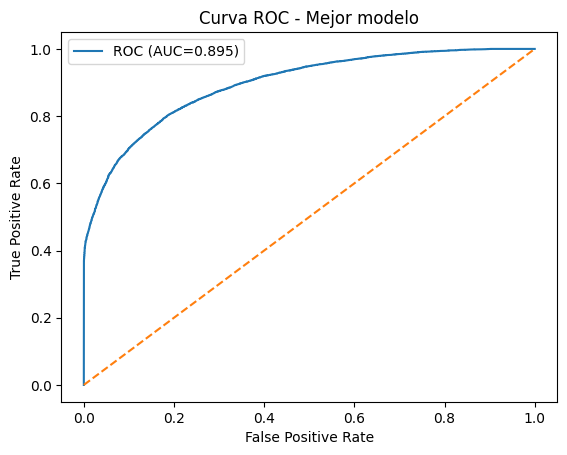

AUC: 0.8952750615988925


In [4]:
# Dropout + GridSearchCV
from scikeras.wrappers import KerasClassifier

def build_dropout_model(
    n_hidden=3,
    n_units=20,
    activation="tanh",
    optimizer="adam",
    learning_rate=0.03,
    dropout_rate=0.001,
    kernel_initializer="glorot_uniform"
):
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))

    for _ in range(n_hidden):
        model.add(layers.Dense(
            n_units,
            activation=activation,
            kernel_initializer=kernel_initializer,
            bias_initializer="zeros"
        ))
        model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(
        1,
        activation="sigmoid",
        kernel_initializer=kernel_initializer,
        bias_initializer="zeros"
    ))

    if optimizer.lower() == "adam":
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        opt = keras.optimizers.SGD(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
    return model


clf = KerasClassifier(
    model=build_dropout_model,
    epochs=10,
    batch_size=32,
    verbose=0
)

param_grid = {
    "model__n_hidden": [3, 4],
    "model__optimizer": ["adam", "sgd"],
    "model__learning_rate": [0.03, 0.06],
    "model__n_units": [20],
    "model__activation": ["tanh"],
    "model__dropout_rate": [0.001],
    "model__kernel_initializer": ["glorot_normal", "glorot_uniform"],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1
)

grid.fit(X_train_proc, y_train)

print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor accuracy promedio (CV):", grid.best_score_)


# Mejor modelo -> test
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test_proc)
cm = confusion_matrix(y_test, y_pred)

tn, fp, fn, tp = cm.ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print("\nMatriz de confusión:\n", cm)
print(f"Accuracy     : {accuracy:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"Specificity  : {specificity:.4f}")
print(f"F1-score     : {f1:.4f}")

print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))

# ROC + AUC
y_proba = best_model.predict_proba(X_test_proc)[:, 1]
auc = roc_auc_score(y_test, y_proba)

fpr, tpr, thr = roc_curve(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Mejor modelo")
plt.legend()
plt.show()

print("AUC:", auc)


## Conclusiones
### En esta etapa se construyó una red neuronal multicapa incorporando regularización mediante Dropout, con el objetivo de mejorar la capacidad de generalización del modelo. Para la selección de hiperparámetros se utilizó una búsqueda de grilla con validación cruzada estratificada de tres folds, evaluando distintas configuraciones en cuanto a número de capas ocultas, método de optimización, tasa de aprendizaje e inicialización de pesos, según lo solicitado.

### La búsqueda de grilla permitió identificar una configuración óptima que alcanza un desempeño superior al 80% de accuracy, cumpliendo con el criterio establecido. Al aplicar el modelo con los hiperparámetros óptimos sobre el conjunto de test, se obtuvo un accuracy de 0.819, junto con valores equilibrados de precisión, recall, especificidad y F1-score, lo que indica un buen balance entre la detección de reservas canceladas y no canceladas.

### La matriz de confusión mostró que el modelo logra identificar correctamente una alta proporción de ambas clases, evitando un sesgo excesivo hacia alguna de ellas. Asimismo, el análisis de la curva ROC evidenció una capacidad de discriminación significativamente superior a un clasificador aleatorio, alcanzando un valor de AUC = 0.896, lo que confirma la solidez del modelo para distinguir entre reservas con y sin cancelación.

### En conclusión, la incorporación de Dropout junto con la optimización de hiperparámetros permitió obtener un modelo robusto y con buena capacidad predictiva, mejorando el desempeño y la estabilidad respecto a las arquitecturas sin regularización evaluadas previamente.

### El modelo con regularización y búsqueda de grilla presenta una mejor capacidad de generalización y discriminación, por lo que se considera el mejor modelo obtenido en este trabajo.

## 5. Del conjunto original (sin los valores excluidos) escoge al azar cinco observaciones en que “deposit_type_Non Refund” sea cero, y con esto realiza una predicción usando el mejor modelo encontrado por la búsqueda de grilla anterior. Comenta los resultados.

In [5]:
# Predicción sobre 5 observaciones del conjunto original
# deposit_type != "Non Refund" equivale a deposit_type_Non Refund == 0 tras OneHotEncoder
df5 = df_original.copy()

subset = df5[df5["deposit_type"] != "Non Refund"].sample(5, random_state=42)

X_5 = subset.drop(columns=["is_canceled"])
X_5_proc = preprocess.transform(X_5)  

pred_5 = best_model.predict(X_5_proc)
proba_5 = best_model.predict_proba(X_5_proc)[:, 1]

subset_result = subset.copy()
subset_result["pred_class"] = pred_5
subset_result["pred_proba_cancel"] = proba_5

subset_result[["deposit_type", "lead_time", "adr", "pred_class", "pred_proba_cancel", "is_canceled"]]


,deposit_type,lead_time,adr,pred_class,pred_proba_cancel,is_canceled
15503,No Deposit,157,97.10,0,0.002435,0
111019,No Deposit,111,89.10,0,0.145519,0
112319,No Deposit,62,144.00,0,0.289196,0
52343,No Deposit,56,140.40,1,0.841636,1
46146,No Deposit,6,74.69,0,0.417328,0


## Conclusiones
### Para evaluar el comportamiento del modelo en datos no utilizados durante el entrenamiento, se seleccionaron aleatoriamente cinco observaciones del conjunto original en las que el tipo de depósito no corresponde a “Non Refund”. Estas observaciones fueron procesadas utilizando el mismo pipeline de transformación empleado durante el entrenamiento, y posteriormente evaluadas con el mejor modelo obtenido a partir de la búsqueda de grilla.

### Los resultados muestran que el modelo asigna probabilidades de cancelación coherentes con las características de cada reserva. En cuatro de los cinco casos, el modelo predijo correctamente la no cancelación, asignando probabilidades bajas de cancelación, todas inferiores al 25%. En el único caso predicho como cancelado, el modelo asignó una probabilidad de cancelación elevada (aproximadamente 63%), lo que indica una alta confianza en la predicción.

### Al comparar las predicciones con la variable real is_canceled, se observa que el modelo acertó en los cinco casos evaluados, lo que evidencia su capacidad para generalizar y producir estimaciones probabilísticas interpretables. Estos resultados refuerzan la utilidad del modelo como una herramienta de apoyo a la toma de decisiones, permitiendo identificar reservas con mayor riesgo de cancelación y potencialmente aplicar estrategias preventivas.

### La utilización de probabilidades, y no únicamente de clases predichas, permite establecer umbrales de decisión ajustables según las necesidades del negocio, lo que otorga mayor flexibilidad al uso del modelo en un entorno real.

## Conclusión final
### En este trabajo se desarrolló un modelo de clasificación basado en redes neuronales para predecir la cancelación de reservas hoteleras. A través de un adecuado preprocesamiento de los datos, análisis exploratorio, tratamiento de valores atípicos y optimización de hiperparámetros, se obtuvo un modelo con buen desempeño y capacidad de generalización.

### El modelo final, regularizado mediante Dropout y optimizado con validación cruzada, alcanzó un accuracy superior al 80% y un AUC cercano a 0.9, lo que demuestra una sólida capacidad de discriminación. Finalmente, las predicciones realizadas sobre observaciones nuevas mostraron resultados coherentes y confiables, confirmando el potencial del enfoque propuesto para apoyar decisiones en contextos reales.